In [4]:
import pandas as pd

# Define positive and negative keywords
positive_keywords = ['positive', 'excellent', 'great', 'good', 'well', 'brilliant', 'recommend', 'fantastic', 'seamless', 'easy', 'value', 'first class', 'outstanding', 'quick', 'efficient', 'competitive', 'friendly', 'flexible']
negative_keywords = ['negative', 'poor', 'bad', 'problem', 'issue', 'complaint', 'unhappy', 'disappointed', 'worse', 'difficult', 'wait', 'delay', 'hassle']

# Load the data from the CSV file
data = pd.read_csv(r'C:\Users\HP\FastAPI\Evaluation-dataset.csv', header=None)

# Initialize lists for comments and labels
comments = []
labels = []

# Function to determine sentiment from keywords
def determine_sentiment(text):
    for word in positive_keywords:
        if word in text.lower():
            return 'positive'
    for word in negative_keywords:
        if word in text.lower():
            return 'negative'
    return 'unknown'

# Process each row of data
for index, row in data.iterrows():
    # Combine all columns into a single string
    combined_row = ' '.join(row.dropna().astype(str))
    words = combined_row.split()

    # Separate the last word as the label and the rest as the comment
    comment = ' '.join(words[:-1])
    label = words[-1]

    # If the last word is not a sentiment label, determine the sentiment from the comment
    if label not in ['positive', 'negative']:
        label = determine_sentiment(comment)

    # Filter only rows with labels 'positive' or 'negative'
    if label in ['positive', 'negative']:
        comments.append(comment)
        labels.append(label)

# Create a DataFrame from the lists
df = pd.DataFrame({
    'Comment': comments,
    'Label': labels
})

# Save the DataFrame to a CSV file
df.to_csv(r'C:\Users\HP\FastAPI\Processed-dataset.csv', index=False)

# Count the number of positive and negative comments
label_counts = df['Label'].value_counts()

# Print the counts
print("Number of positive comments:", label_counts.get('positive', 0))
print("Number of negative comments:", label_counts.get('negative', 0))

# Print the DataFrame
print(df)

Number of positive comments: 8210
Number of negative comments: 1341
                                                Comment     Label
0     Tires where delivered to the garage of my choi...  positive
1     Easy Tyre Selection Process, Competitive Prici...  positive
2     Very easy to use and good value for money. val...  positive
3     Really easy and convenient to arrange ease of ...  positive
4     It was so easy to select tyre sizes and arrang...  positive
...                                                 ...       ...
9546  I ordered the wrong tyres, however [REDACTED] ...  positive
9547  Good experience, first time I have used [REDAC...  positive
9548  I ordered the tyre I needed on line, booked a ...  positive
9549  Excellent service from point of order to fitti...  positive
9550       Seamless, well managed at both ends. I would  positive

[9551 rows x 2 columns]


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, roc_curve, auc, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

# Load the data from a CSV file
data = pd.read_csv(r'C:\Users\HP\FastAPI\Processed-dataset.csv')

# Split the data into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Prepare training data for model
train_reviews = train_data['Comment']
train_labels = train_data['Label']

# Prepare test data for model
test_reviews = test_data['Comment']
test_labels = test_data['Label']

# Define a pipeline for the model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

# Define parameter grid for GridSearchCV
param_grid = [
    {
        'clf': [LogisticRegression()],
        'clf__C': [0.1, 1, 10, 20],
        'tfidf__max_features': [1000, 2000, 3000, 4000],
    },
    {
        'clf': [LinearSVC()],
        'clf__C': [0.1, 1, 10, 20],
        'tfidf__max_features': [1000, 2000, 3000, 4000],
    },
    {
        'clf': [RandomForestClassifier()],
        'clf__n_estimators': [50, 100, 200 , 300],
        'clf__max_depth': [None, 10, 20, 30, 50],
        'tfidf__max_features': [1000, 2000, 3000, 4000],
    }
]

# Perform GridSearchCV to find the best model
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(train_reviews, train_labels)

# Print the best algorithm chosen
best_algorithm = grid_search.best_estimator_.named_steps['clf']
print("Best Algorithm:", best_algorithm)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Save the best model to a pickle file
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Predict sentiments on the test data
predicted_labels = best_model.predict(test_reviews)

# Evaluate the model
report = classification_report(test_labels, predicted_labels)
print(report)

# Calculate F1 score
f1 = f1_score(test_labels, predicted_labels, average='micro')
print("F1 Score (Micro):", f1)


Fitting 5 folds for each of 112 candidates, totalling 560 fits
Best Algorithm: LogisticRegression(C=10)
              precision    recall  f1-score   support

    negative       0.79      0.73      0.76       268
    positive       0.96      0.97      0.96      1643

    accuracy                           0.94      1911
   macro avg       0.87      0.85      0.86      1911
weighted avg       0.93      0.94      0.93      1911

F1 Score (Micro): 0.9351125065410779


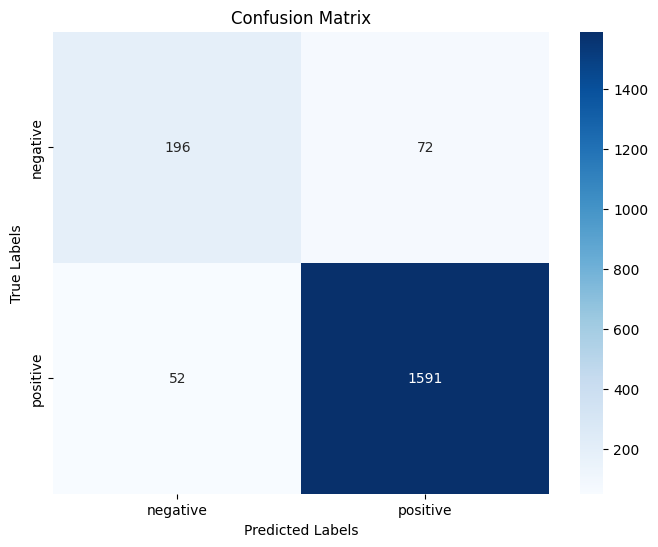

In [8]:
# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [9]:
# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))

# Calculate and plot Precision-Recall curve directly for the positive class
precision, recall, _ = precision_recall_curve(test_labels_binarized, predicted_labels_binarized)
average_precision = average_precision_score(test_labels_binarized, predicted_labels_binarized)
plt.plot(recall, precision, label=f'Positive (AP = {average_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

NameError: name 'test_labels_binarized' is not defined

<Figure size 800x600 with 0 Axes>

data_set = "https://www.google.com/url?q=https%3A%2F%2Fdrive.google.com%2Ffile%2Fd%2F1m9tsFuXxHUAOPxNqCeLFVkDhINSmoMf4%2Fview%3Fusp%3Dsharing"